In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

In [19]:
df = pd.read_csv('/Users/Alby/Desktop/rethinking statistics/Rethinking/Data/tulips.csv', 
                sep = ';')

df = df.dropna()
df.dropna() 

#center variables
df.water = df.water - df.water.mean() 
df.shade = df.shade - df.shade.mean() 
print(df.columns)

print(df.blooms.mean())
#print(df.water) ; print(df.shade) ; print(df.bed) 

Index(['bed', 'water', 'shade', 'blooms'], dtype='object')
128.99370370370372


## Make the categorical variables into integers. Check priors 

In [180]:
#make categorical variables
a = pd.Categorical(df.bed) 
df['bed_id'] = a.codes
#print(df.bed_id)

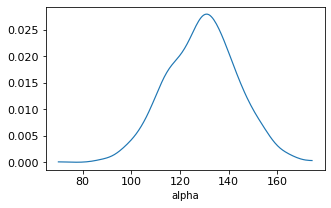

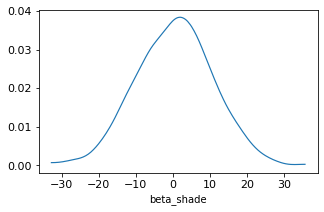

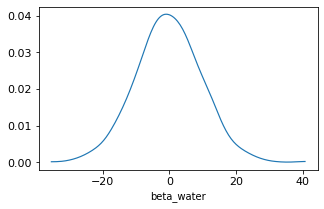

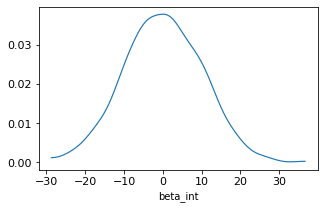

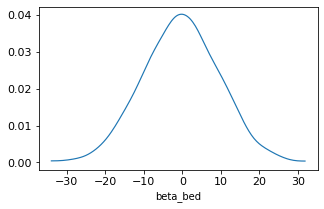

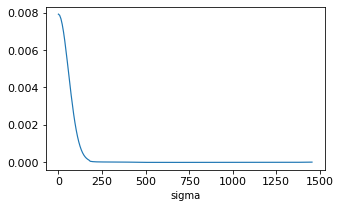

In [98]:
prior_sample = pm.sample_prior_predictive(1000, model)

varnames = ['alpha', 'beta_shade', 'beta_water', 'beta_int', 'beta_bed', 'sigma']

for i in varnames : 
    plt.figure(figsize = (5, 3))
    az.plot_kde(prior_sample[i])
    plt.xlabel(i) 

## fit a model that looks at plant shade, water, and the bed it was in, as well as an interaction effect btwn shade and water

In [161]:
model = pm.Model() 

with model : 
    alpha = pm.Normal('alpha', mu = 129, sigma = 15)
    beta_shade = pm.Normal('beta_shade', mu = 0, sigma = 100)
    beta_water = pm.Normal('beta_water', mu = 0, sigma = 100)
    beta_int = pm.Normal('beta_int', mu = 0, sigma = 100)
    beta_bed = pm.Normal('beta_bed', mu = 0, sigma = 100, shape = len(df.bed_id.unique()))
    sigma = pm.HalfCauchy('sigma', 2) 
    
    mu = pm.Deterministic('mu', alpha + beta_water*df.water + beta_shade*df.shade \
                          + beta_int * df.water*df.shade + beta_bed[df.bed_id.values])
    blooms = pm.Normal('blooms', mu = mu, sd = sigma, observed = df.blooms)
    
    trace = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_bed, beta_int, beta_water, beta_shade, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:04<00:00, 1776.84draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2088d450>,
      dtype=object)

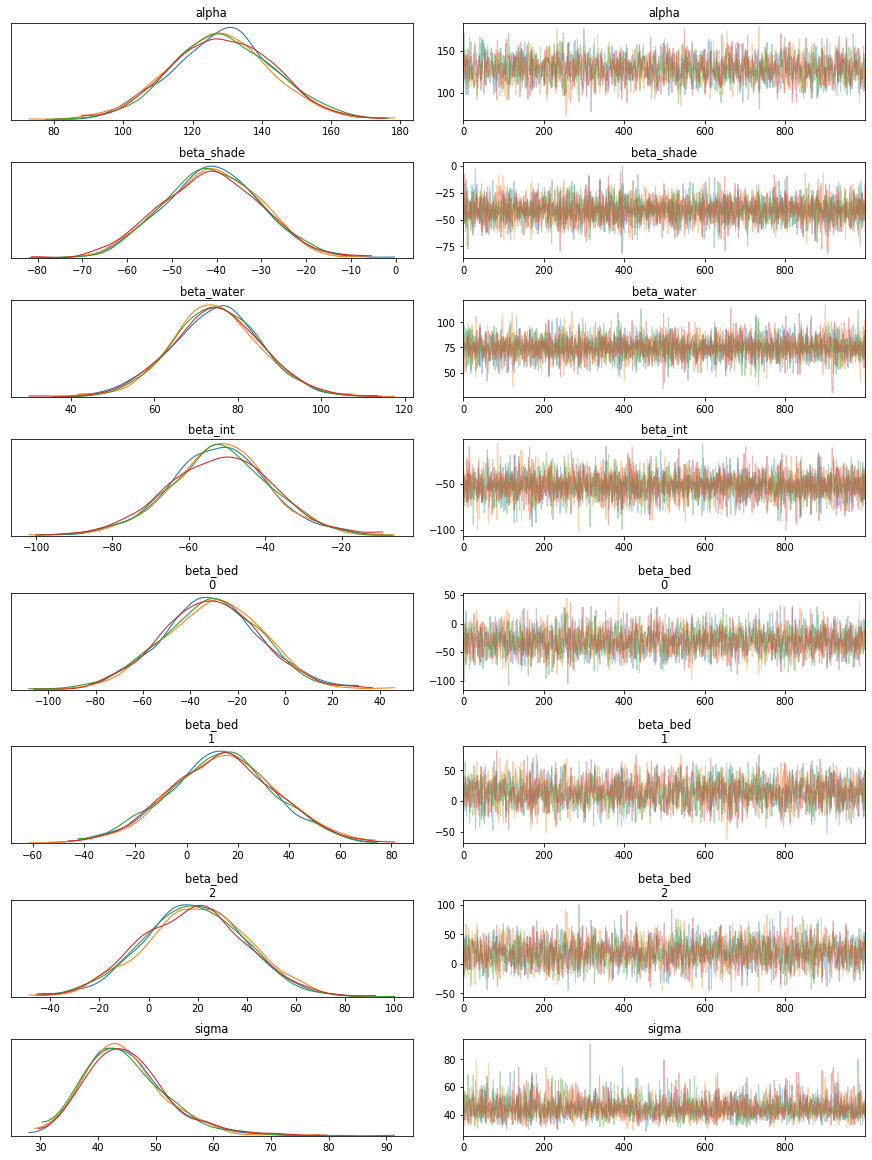

In [162]:
az.plot_trace(trace, ['~mu'])

In [163]:
# lets draw some samples mf
samples = pm.sample_posterior_predictive(trace, 1000, model)

pm.summary(trace, varnames) 

/opt/anaconda3/envs/pymc36/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 841.36it/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,128.591,14.579,101.031,155.573,0.320,0.226,2079.0,2079.0,2080.0,2644.0,1.0
beta_shade,-41.123,10.950,-61.910,-21.926,0.144,0.105,5763.0,5404.0,5761.0,3008.0,1.0
beta_water,74.894,10.788,55.204,95.473,0.158,0.112,4655.0,4638.0,4733.0,2972.0,1.0
beta_int,-51.938,13.304,-77.287,-26.340,0.190,0.137,4918.0,4750.0,4943.0,2931.0,1.0
beta_bed[0],-30.750,20.754,-70.539,6.725,0.410,0.290,2564.0,2564.0,2560.0,3034.0,1.0
beta_bed[1],13.962,20.549,-26.177,51.533,0.420,0.297,2398.0,2398.0,2397.0,2755.0,1.0
beta_bed[2],18.692,20.992,-22.157,56.783,0.419,0.296,2508.0,2508.0,2506.0,2809.0,1.0
sigma,44.874,7.084,32.104,57.849,0.130,0.094,2959.0,2822.0,3120.0,2563.0,1.0


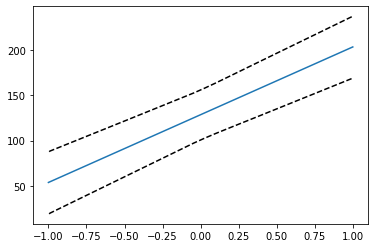

In [164]:
#plot water holding bed and shade constant
shade_seq = np.zeros(100)
bed_seq = np.zeros(100) 
water_seq = np.linspace(-1, 1, 3) 
water_pred = trace['alpha'] + trace['beta_water'] * water_seq[:, None]

#plt.plot(df.loc[df['shade'] == 0].water, df.loc[df['shade'] == 0].blooms, 'C0o')
plt.plot(water_seq, water_pred.mean(1))
az.plot_hpd(water_seq, water_pred.T, 
           fill_kwargs={'alpha': 0},
           plot_kwargs={'alpha':1, 'color':'k', 'ls':'--'})

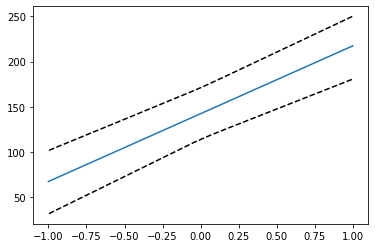

In [165]:
#plot water holding bed and shade constant
shade_seq = np.zeros(100)
bed_seq = np.linspace(1, 1, 3)
water_seq = np.linspace(-1, 1, 3) 
water_pred = trace['alpha'] + trace['beta_water'] * water_seq[:, None] + trace['beta_bed'][:, 1]*bed_seq[:, None]

#plt.plot(df.loc[df['shade'] == 0].water, df.loc[df['shade'] == 0].blooms, 'C0o')
plt.plot(water_seq, water_pred.mean(1))
az.plot_hpd(water_seq, water_pred.T, 
           fill_kwargs={'alpha': 0},
           plot_kwargs={'alpha':1, 'color':'k', 'ls':'--'})

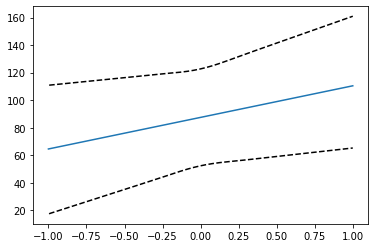

In [166]:
#plot water  w shade = 1 
shade_seq = np.linspace(1, 1, 3)
bed_seq = np.linspace(1, 1, 3)
water_seq = np.linspace(-1, 1, 3) 
water_pred = trace['alpha'] + trace['beta_water'] * water_seq[:, None] + trace['beta_int'] * water_seq[:, None] * shade_seq[:, None]\
+ trace['beta_shade'] * shade_seq[:, None]
#plt.plot(df.loc[df['shade'] == 0].water, df.loc[df['shade'] == 0].blooms, 'C0o')
plt.plot(water_seq, water_pred.mean(1))
az.plot_hpd(water_seq, water_pred.T, 
           fill_kwargs={'alpha': 0},
           plot_kwargs={'alpha':1, 'color':'k', 'ls':'--'})

## Plot the interaction effects of water and shade on plant growth 

[[ -6.37296202  88.52644849]
 [ 18.86818385  87.65932232]
 [ 17.28711572 110.81856488]]
mu =  [[ 22.10144488  11.48999331  28.12139128 ... -19.92053917   3.9564891
   56.25546648]
 [ 40.17194503  41.69383369  65.38033251 ...  11.05380462  40.15805465
   42.12856075]
 [ 58.24244518  71.89767408 102.63927373 ...  42.02814841  76.3596202
   28.00165502]] fin
[[137.04334164 204.48309227]
 [101.03137892 155.57295628]
 [ 52.89639494 121.99340527]]
mu =  [[165.04509882 172.30684802 178.21087228 ... 137.31125043 132.29699203
  179.0686272 ]
 [128.18981395 139.24570813 151.38372119 ... 102.62153616 115.461651
  118.46053272]
 [ 91.33452908 106.18456824 124.5565701  ...  67.93182189  98.62630998
   57.85243825]] fin
[[247.61811728 338.38438869]
 [168.98592917 237.41254354]
 [ 65.22022078 160.97311995]]
mu =  [[307.98875276 333.12370274 328.30035328 ... 294.54304002 260.63749496
  301.88178791]
 [216.20768287 236.79758257 237.38710987 ... 194.18926769 190.76524735
  194.79250469]
 [124.42661298 1

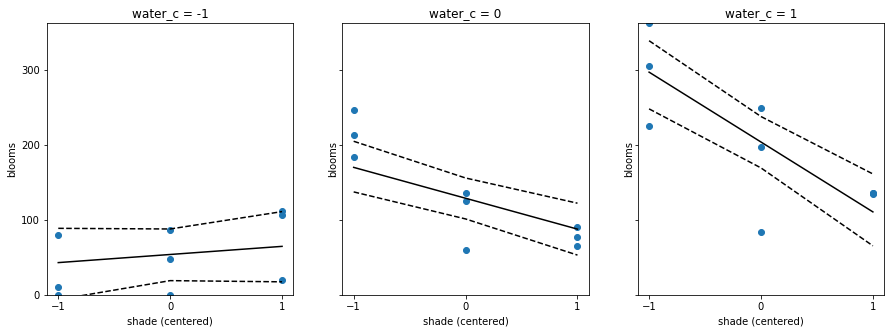

In [170]:
#take a figure object f, and the axes in axs it goes (nrows, ncols, sharing the same dimesniosn, )
f, axs = plt.subplots(1, 3, sharey = True, figsize = (15, 5)) 
shade_seq = range(-1, 2, 1) 

mu = np.zeros((len(shade_seq), len(trace['alpha']))) # three rows x len(trace) values 

for ax, w in zip(axs, range(-1, 2, 1)) : 
    d_subset = df.loc[df['water'] == w] #each time we loop, grab a new val of water, and grab the subset of df that has that val of water
    ax.plot(d_subset.shade, d_subset.blooms, 'C0o')
    for i, shade in enumerate(shade_seq) : #enum returns an index i(1-3 for shade seq), and a shade val (-1 to 1)
        mu[i] = trace['alpha'] + trace['beta_shade'] * shade + trace['beta_water'] * w +\
        trace['beta_int'] * w * shade 
    mu_hpd = pm.hpd(mu.T) #here we transpose to align with pymc style hpd-- trace rows, shade vals (-1 to 1) as  cols
    print(mu_hpd) 
    print('mu = ', str(mu), 'fin') 
    mu_mean = mu.mean(1) # take mean for each shade value
    ax.plot(shade_seq, mu_hpd.T[0], 'k--')
    ax.plot(shade_seq, mu_hpd.T[1], 'k--') # transpose back so that we can slice lower with [0] and upper w [1]
    ax.plot(shade_seq, mu_mean, 'k')
    ax.set_ylim(0,362)
    ax.set_ylabel('blooms')
    ax.set_xlabel('shade (centered)')
    ax.set_title('water_c = {:d}'.format(w))
    ax.set_xticks(shade_seq)
    ax.set_yticks(range(0, 301, 100))

## Same thing, but now also look at what bed plant was in (columns) 

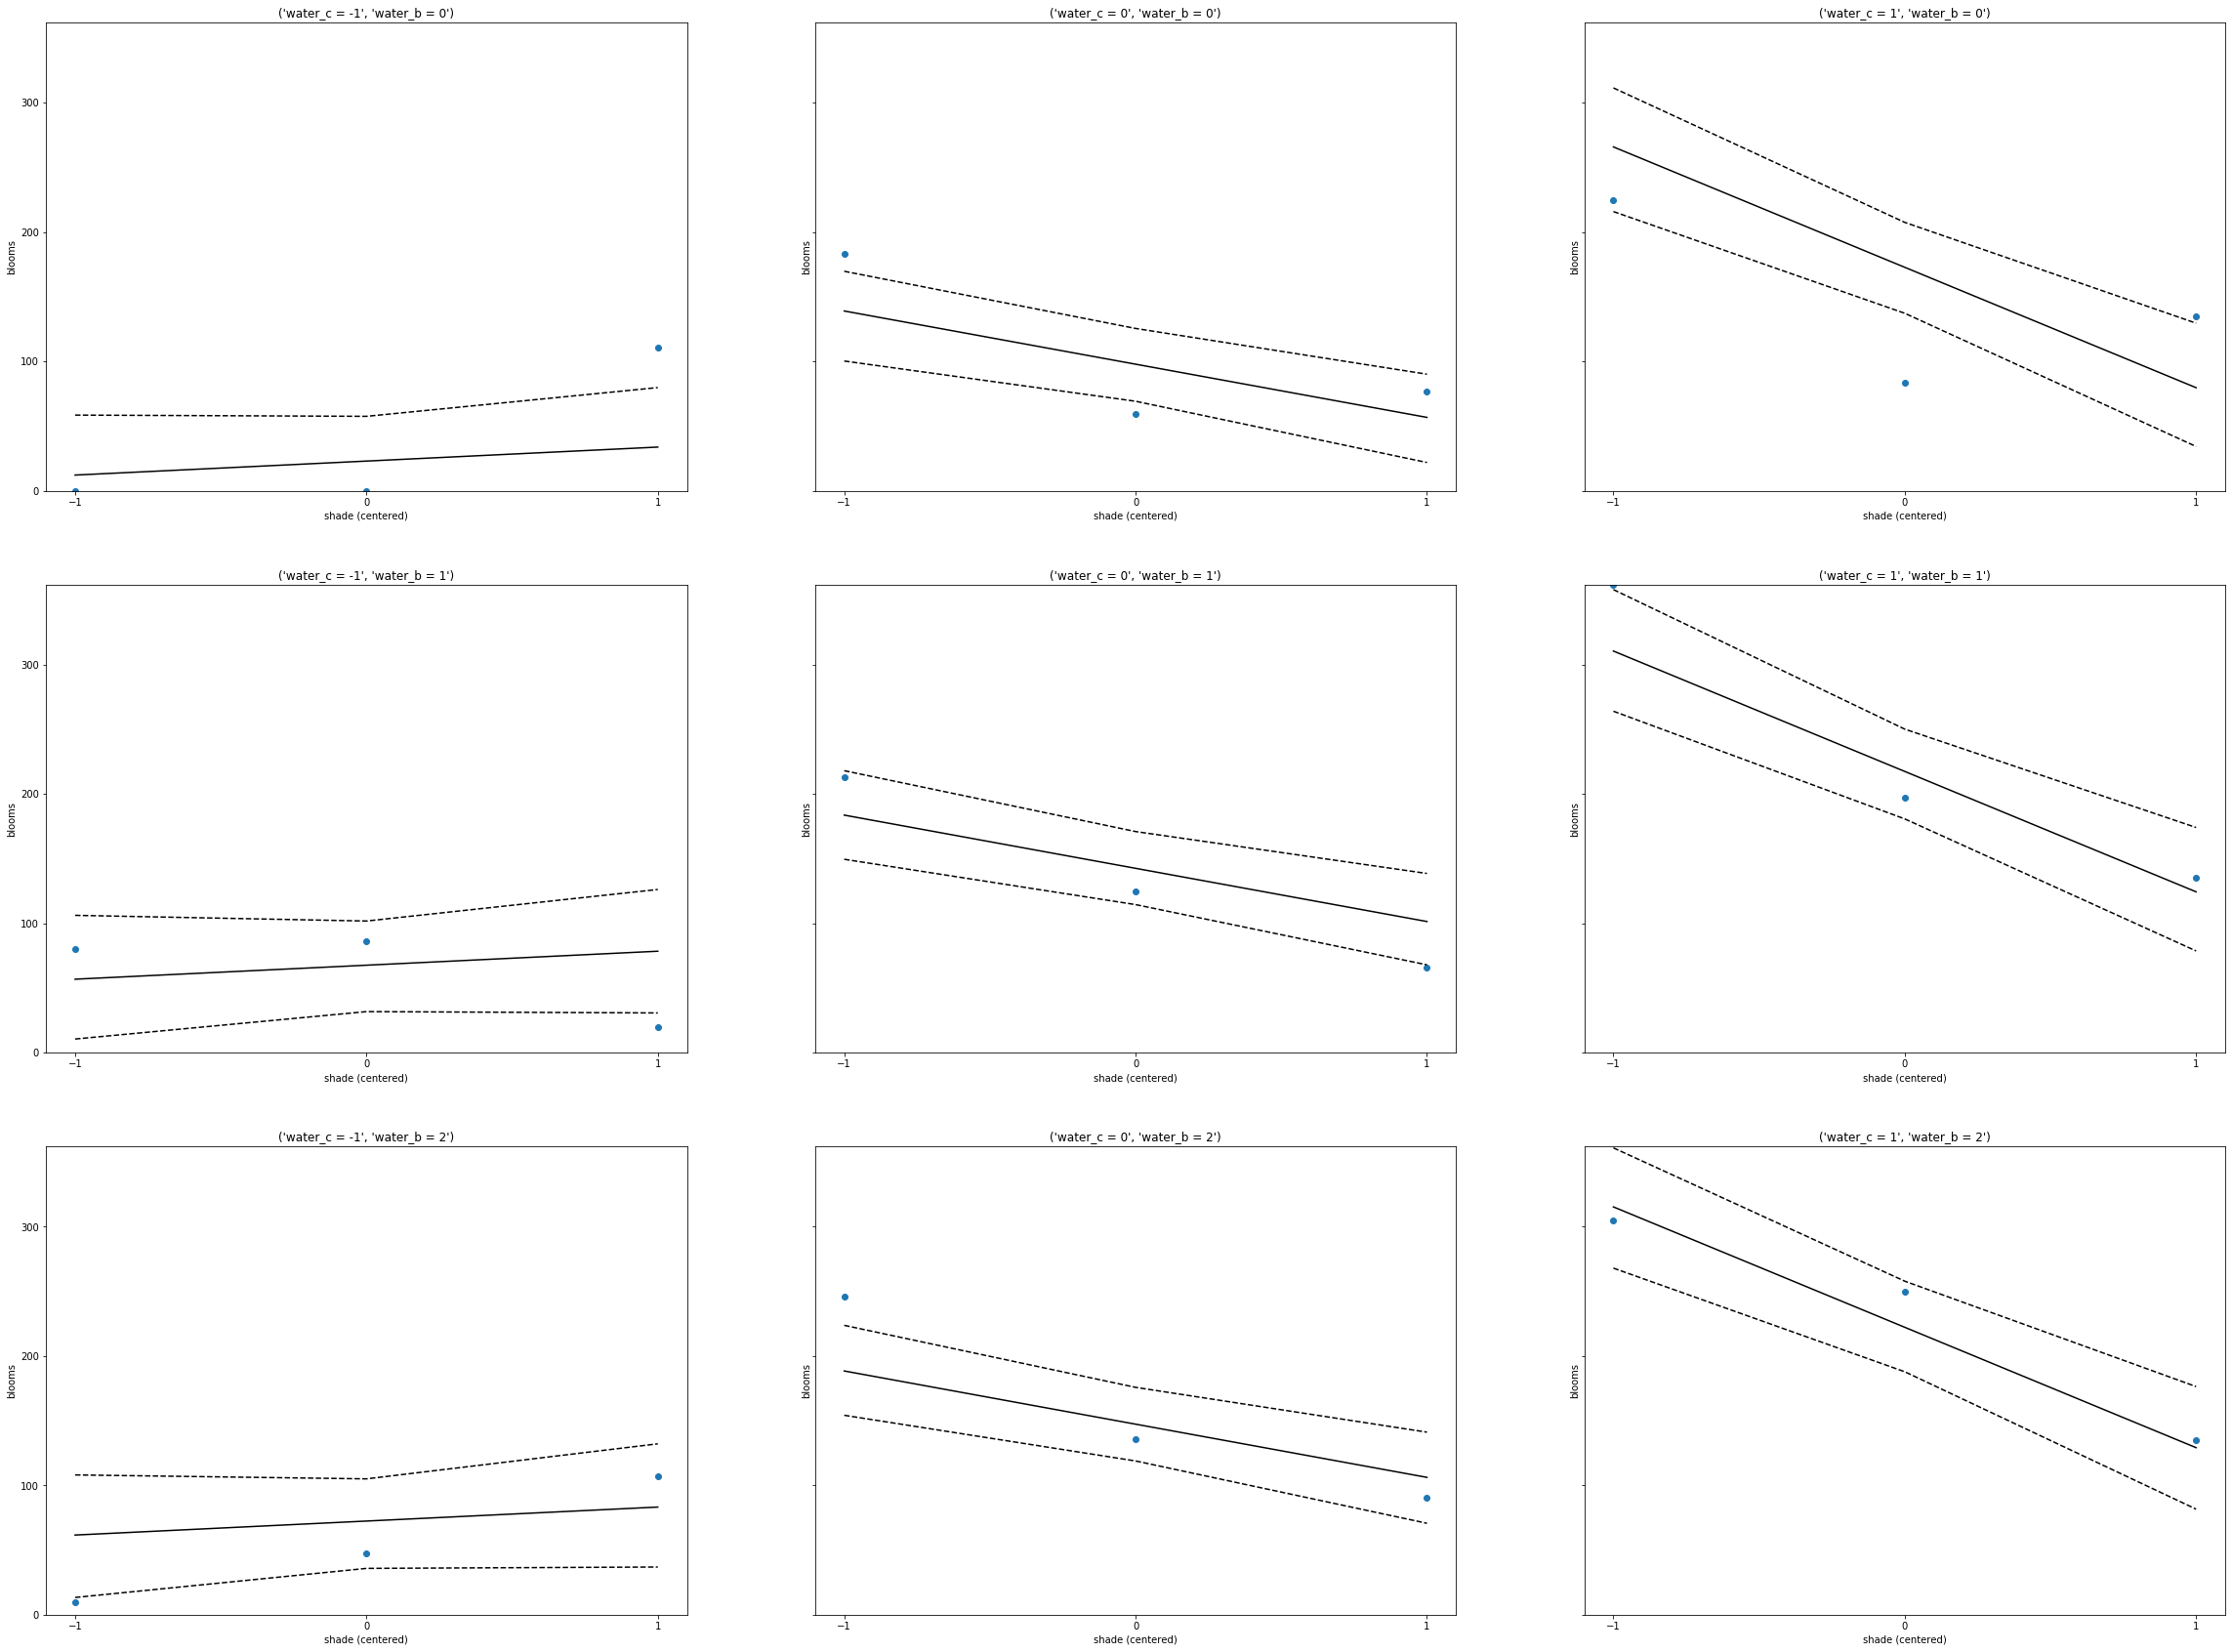

In [182]:
#take a figure object f, and the axes in axs it goes (nrow of graphs, ncols, sharing the same y dimesniosn, )
f, axs = plt.subplots(3, 3, sharey = True, figsize = (40, 30)) 
shade_seq = range(-1, 2, 1) 

mu = np.zeros((len(shade_seq), len(trace['alpha']))) # three rows x len(trace) values 

for b in range(0, 3, 1) : 
    for ax, w in zip(axs[b, :], range(-1, 2, 1)) : #iterate over axis row b
        d_subset = df.loc[(df['water'] == w) & (df['bed_id'] == b)] #each time we loop, grab a new val of water, and grab the subset of df that has that val of water
        ax.plot(d_subset.shade, d_subset.blooms, 'C0o')
        for i, shade in enumerate(shade_seq) : #enum returns an index i(1-3 for shade seq), and a shade val (-1 to 1)
            mu[i] = trace['alpha'] + trace['beta_shade'] * shade + trace['beta_water'] * w +\
            trace['beta_int'] * w * shade  + trace['beta_bed'][:, b]

        mu_hpd = pm.hpd(mu.T) #here we transpose to align with pymc style hpd-- trace rows, shade vals (-1 to 1) as  cols
        mu_mean = mu.mean(1) # take mean for each shade value
        ax.plot(shade_seq, mu_hpd.T[0], 'k--')
        ax.plot(shade_seq, mu_hpd.T[1], 'k--') # transpose back so that we can slice lower with [0] and upper w [1]
        ax.plot(shade_seq, mu_mean, 'k')
        ax.set_ylim(0,362)
        ax.set_ylabel('blooms')
        ax.set_xlabel('shade (centered)')
        ax.set_title(('water_c = {:d}'.format(w), 'water_b = {:d}'.format(b)))
        ax.set_xticks(shade_seq)
        ax.set_yticks(range(0, 301, 100))